In [ ]:
import Pkg 
Pkg.add("Glob")
Pkg.add("PlotlyJS")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")

In [ ]:
using LinearAlgebra
using Statistics
using Glob
using CSV
using DataFrames
using Plots

In [ ]:
function pdb2matrix(pdb_file::String)
    x,y,z = [], [], []
    for line in eachline(open(pdb_file))
        if startswith(line, "ATOM") && strip(line[13:16]) == "CA"
            push!(x, parse(Float64,strip(line[31:38])))
            push!(y, parse(Float64,strip(line[39:46])))
            push!(z, parse(Float64,strip(line[47:54])))
        end
        if startswith(line, "TER")
            break
        end
    end
    m = hcat(x,y,z)
    return m
end

function xyz2matrix(input_xyz)
    # Imports .xyz file format as data frame, and converts it to an N x 3 Matrix
    raw_xyz=readdlm(input_xyz)
    natoms=size(raw_xyz)[1]
    just_coords=Array{Float64}(raw_xyz[2:natoms,2:4])
    return just_coords
end

function translate_to_centroid(coord_matrix)
    # Normalises the molecular coordinates by centering them.
    center = [mean(coord_matrix[:,1]);mean(coord_matrix[:,2]);mean(coord_matrix[:,3])]
    centroid = transpose(center)
    translated_geom = broadcast(-,coord_matrix,centroid)
    return translated_geom
end

function cross_covariance_matrix(Pmatrix,Qmatrix)
    # Cross covariance matrix gives measure of variability between two matrices
    CCmatrix = transpose(Pmatrix) * Qmatrix
    return CCmatrix
end

function optimal_rotation_matrix(CCmatrix)
    # Returns 3x3 matrix that can be applied to P to get Q
    ORmatrix = sqrt(transpose(CCmatrix)*CCmatrix)*inv(CCmatrix)
    return ORmatrix
end

function kabsch(m1,m2)

    normalisedP = (translate_to_centroid(m1))
    normalisedQ = (translate_to_centroid(m2))

    xcov = cross_covariance_matrix(normalisedP,normalisedQ)
    orot = optimal_rotation_matrix(xcov)

    num_atoms = size(normalisedP)[1]
    rotated = zeros(Float64,num_atoms,3)

    for i=1:num_atoms
        rotated[i,:] = orot*normalisedP[i,:]
    end

    RMSD_value = norm(rotated-normalisedQ)
    return RMSD_value
end

function matrix2fragments(matrix, wsize=5)
    msize = size(matrix)[1]-wsize
    megam = [matrix[i:i+wsize,:] for i in 1:msize]
    return megam
end

function kabsh_matrix(megax)    
    try        
        n = size(megax)[1]  # Change this to the desired size
        matrix = zeros(Float64, n, n)

        for i = 1:n # Fill the upper triangle
            for j = i+1:n  # Ensure j >= i for the upper triangle
                matrix[i, j] = kabsch(megax[i], megax[j])
            end
        end
        return sum(matrix)/(n*n)
    catch 
        return 0
    end
end

In [ ]:
function fxdir(dirpath, printon = false)
        i = 1
        data = []
        for (root, dirs, files) in walkdir(dirpath)
                for file in files
                        try     
                                pdbpath = joinpath(root, file)
                                megax = matrix2fragments(pdb2matrix(pdbpath), 4)
                                nres = size(megax)[1]
                                fxity = kabsh_matrix(megax)
                                push!(data, [i,pdbpath,fxity,nres])
                                if printon
                                println("$i     $pdbpath        $fxity       $nres")
                                end
                        catch 
                                push!(data, [i,pdbpath,0,0])
                                if printon
                                       println("$i     $pdbpath       NA")
                                end
                        end
                        i+=1
                
                end
        end
        return(data)
end
    

In [ ]:
dirpath = "../scop40/bj/"
data = fxdir(dirpath, true)


In [ ]:
scopfx = CSV.read("scop40.tsv", DataFrame; delim="\t", header=false)
rename!(scopfx, ["ndx","path", "fx", "len"])
scopfx


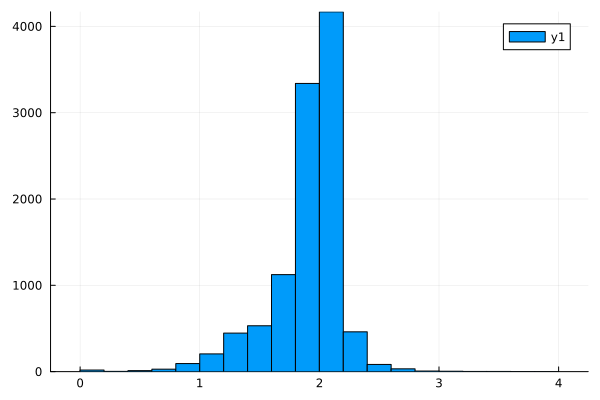

In [101]:
fxs = filter(row -> row.fx < 10, scopfx)
Plots.histogram(fxs.fx, bins=20)

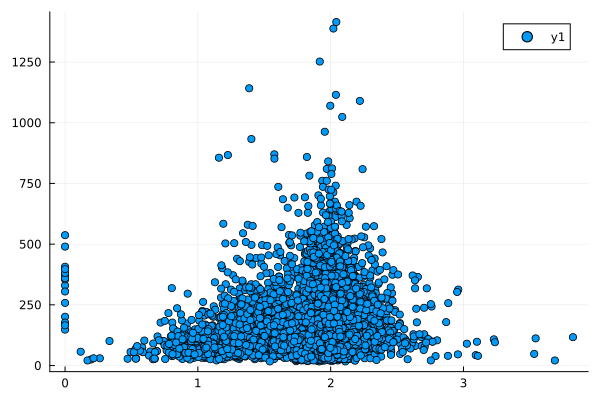

In [98]:
Plots.scatter(fxs.fx, fxs.len)